In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from scipy.fft import rfft, rfftfreq
from scipy.fft import fft2
from scipy.fft import rfftn
from scipy.fft import fftfreq
from skimage.filters import window


import os
import sys
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.insert(0, os.path.join(parent_dir, 'pysta2'))

import pysta
# import stc
# import stcl

# from stcl import load_centers

import pandas as pd
import os

%load_ext autoreload
%autoreload 2

In [2]:
# helper functions for visualization
def box_off():
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def p2p(sta):
    return np.max(sta) - np.min(sta)

def psnr(sta):
    return (np.max(sta.ravel()) - np.min(sta.ravel())) / np.std(sta.ravel())


def plot_temporal_profile(sta, dt):
    tap = sta.shape[0]
#     figsize = (5.5,3.5)
#     plt.figure(figsize=figsize)
    pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
    plt.ylabel('STA')
    print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
    # print('PSNR = {:.2f}'.format(psnr(sta)))

    plt.title('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
#     plt.xlabel('ms')
    
    
def plot_temporal_spectrum(sta, dt):
    wt = rfft(sta, axis=0)
    
    N = sta.shape[0]
    fs = rfftfreq(N, dt)
    
    plt.plot(fs, np.abs(wt), 'o-')
    plt.xlabel('Hz')
    plt.ylabel('FFT amplitude')

    box_off()


def plot_spatial_spectrum(sta_slice, dx=None, windowing='hann', pixel_size=1, precision=2):
    assert len(sta_slice.shape)==2
    
    def set_ticks(ax, fs, precision=precision):
        ticks = range(0, len(fs))
        print_format = "{:." + str(precision) + "f}"
        ticklabels = [print_format.format(p) for p in (fs)]

        ax.set_xticks(ticks)
        ax.set_xticklabels(ticklabels)
        ax.set_xlim(-0.5, len(fs)-0.5)
#         from matplotlib.ticker import FormatStrFormatter
#         ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        
        ax.set_yticks(ticks)
        ax.set_yticklabels(ticklabels)
        ax.set_ylim(-0.5, len(fs)-0.5)

        
    w = fft2(sta_slice * window(windowing, sta_slice.shape))

    if dx is None:
        fs = rfftfreq(sta_slice.shape[0])
    else:
        fs = rfftfreq(sta_slice.shape[0], dx)
    
    # crop and take abs w 
    abs_w = np.abs(w[:len(fs),:len(fs)])
    plt.imshow(abs_w, cmap='gray', origin='lower')

    set_ticks(plt.gca(), fs, precision=precision)
    
    plt.xlabel('frequency')
    plt.ylabel('frequency')
    
    abs_w[0,0] = - np.Inf
    idx_max = np.unravel_index(np.argmax(abs_w, axis=None), abs_w.shape)
    plt.plot(idx_max[1],idx_max[0], 'r*')
    
    
    
def plot_spatio_temporal(sta, height=13, width=13, dt=1000/30, ylabel=None, fig_basename=None):        
    tap = sta.shape[-1]
    figsize = (5.5,3.5)
    plt.figure(figsize=figsize)
    
    plot_temporal_profile(sta, dt)
    
    
#     pysta.plot_temporal_profile(sta, tap, dt, ylim=[-0.5,0.5])
#     if ylabel is not None:
#         plt.ylabel(ylabel)
#     print('peak-to-peak diff. = {:.2f}'.format(p2p(sta)))
#     print('PSNR = {:.2f}'.format(psnr(sta)))
# #     plt.title('peak diff. = {:.2f}'.format(p2p(sta)))
#     plt.xlabel(None)

    if fig_basename is not None:
        plt.savefig(fig_basename + '_temp.pdf', bbox_inches='tight') # https://stackoverflow.com/a/4046233

    plt.figure()
    pysta.plot_stim_slices(sta, height=height, width=width, dt=dt, vmin=-0.5, vmax=0.5)

#     plt.tight_layout()
    
    if fig_basename is not None:
        plt.savefig(fig_basename + '_spatial.pdf', bbox_inches='tight')
    
    
def groupby_dict(df, col, group):
    data = dict()
    for group_val, d in df.groupby(group):
#         print(group_val)
        data[group_val] = d[col].to_list()
    return data


def plot_bar_by_group(info, col, 
                      groupby='cell_type', 
                      group_values = ['ON', 'OFF', 'ON-OFF', 'Unknown'], color=['r','#00A0FF','green', '#A0A0A0']):
    
    means = info.groupby(groupby)[col].mean()[group_values]
    sems = info.groupby(groupby)[col].sem()[group_values]

    plt.bar(group_values, means, yerr=sems,
            width=0.4, color=color, edgecolor='k', linewidth=1,
            capsize=5)
    
    plt.ylabel(col)
    plt.xlabel('cell type')
    
    plt.xlim(-0.5, len(group_values)-0.5)
    box_off()

In [3]:
def calc_spatial_spectrum(sta_reg, idx_peak=None, dx=None):
    
    if idx_peak is None:
        # find pixel with highest variance
        idx_max_var = np.argmax(np.var(sta_reg,axis=0))
        temporal_profile = sta_reg[:,idx_max_var]

        plt.figure(figsize=(12,4))
        plt.plot(temporal_profile, '.-')
        idx_peak = np.argmax(np.abs(temporal_profile))

#         sta_slice = sta_reg[idx_peak,:].reshape(height,width)
        plt.plot(idx_peak, sta_reg[idx_peak, idx_max_var], 'r*')
        plt.xlabel('frame')
        plt.ylabel('STA at pixel {}'.format(idx_max_var))
        box_off()


    sta_slice = sta_reg[idx_peak,:].reshape(height,width)


    plt.figure(figsize=(15,8))
    plt.subplot(121)
    plt.imshow(sta_slice, cmap='gray', origin='lower')

    plt.subplot(122)
    plot_spatial_spectrum(sta_slice, dx)

## load data

In [4]:
# cloud stim data (2021.02.03 - 52x52, 30Hz)
# ln -s ~/data/cloud_stim_data data_cloud_stim
data_path = 'data_cloud_stim'
dataset = '20210203_contrast100'
width = 52
height = 52
fps = 30

In [5]:
data = np.load(os.path.join(data_path, dataset + '.npz'))
info = pd.read_csv(os.path.join(data_path, dataset + '_info.csv'))


stim = data['stim'] - 0.5
spike_counts = data['spike_counts']

len(info)

102

(array([48672000.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0., 48672000.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

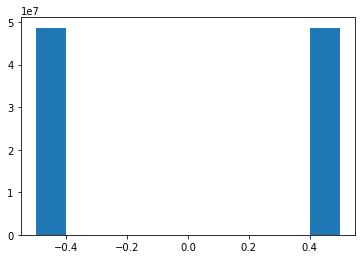

In [6]:
plt.hist(stim.ravel())

In [7]:
info

,channel,cell_type
0,12a,ON-OFF
1,12b,ON-OFF
2,13a,ON-OFF
3,13b,Unknown
4,14a,ON
...,...,...
97,85b,Unknown
98,86a,OFF
99,86b,ON
100,87a,ON-OFF


## load sta results

In [8]:
channel_name = '43b'
sta = np.load(os.path.join('results', dataset, 'sta', channel_name + '.npy'))
reg_sta = np.load(os.path.join('results', dataset, 'rsta', channel_name + '.npy'))

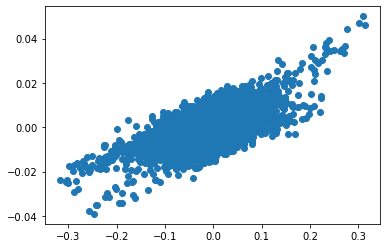

In [9]:
plt.scatter(sta.ravel(), reg_sta.ravel())

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

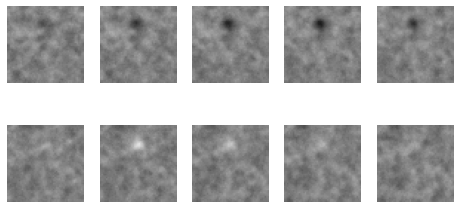

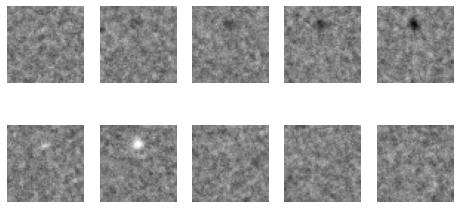

In [10]:
# plot_spatio_temporal(reg_sta)
# plt.figure()
pysta.plot_stim_slices(sta, 52, 52, vmin=-0.4, vmax=0.4)
pysta.plot_stim_slices(reg_sta, 52, 52, vmin=-0.04, vmax=0.04)

## spectrum of STA

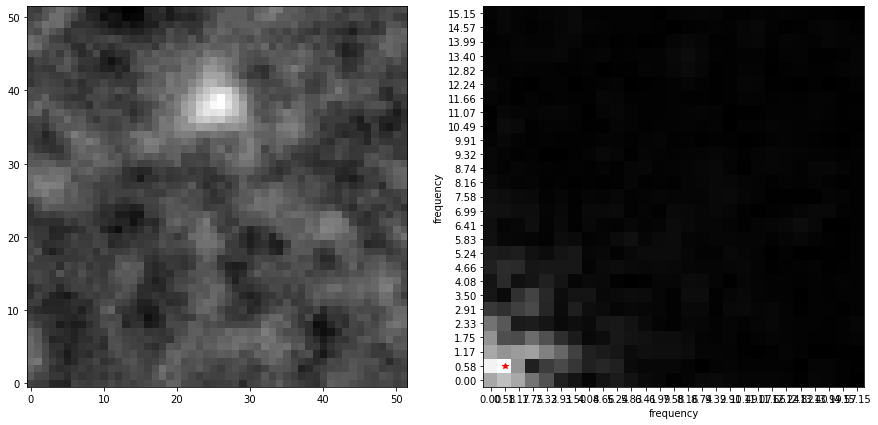

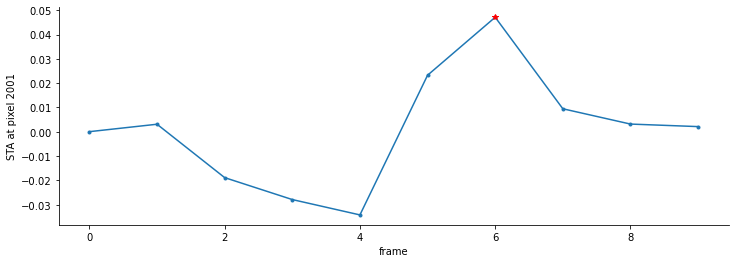

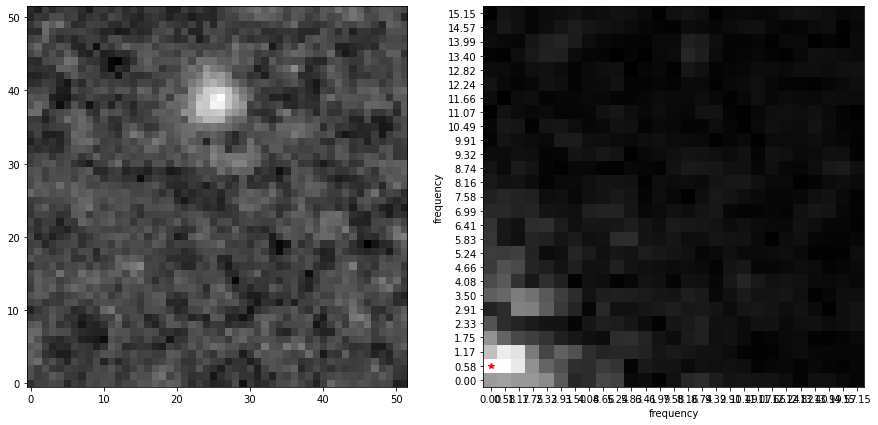

In [11]:
calc_spatial_spectrum(sta, 6, dx=33/1000)
# calc_spatial_spectrum(sta)

plt.savefig(os.path.join('figure',dataset, channel_name + '_sta_space_spectrum.pdf'))

calc_spatial_spectrum(reg_sta, dx=33/1000)

plt.savefig(os.path.join('figure',dataset, channel_name + '_rsta_space_spectrum.pdf'))

## Compare temporal spectrum of STA vs. regularized STA

peak-to-peak diff. = 0.63
peak-to-peak diff. = 0.09


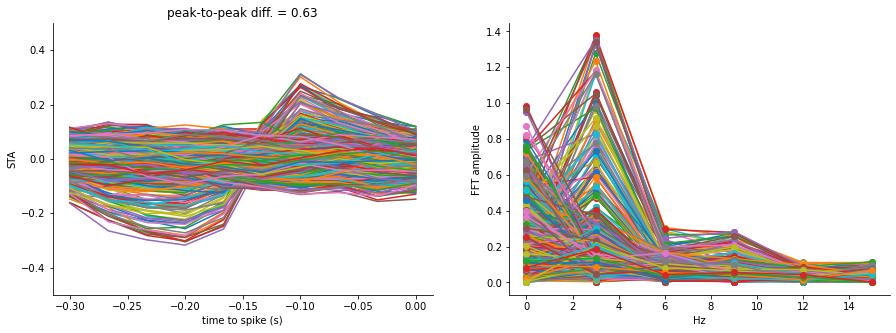

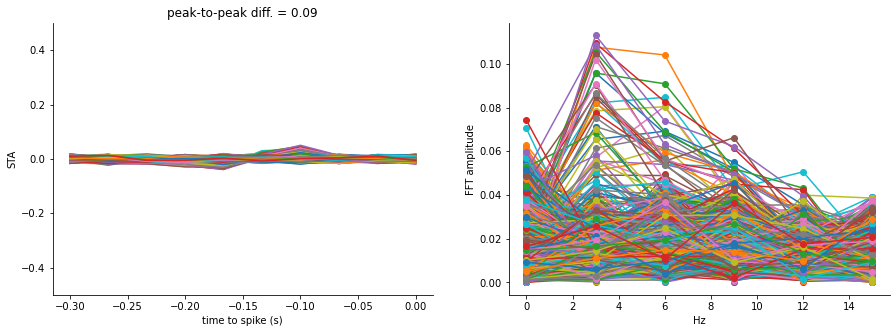

In [13]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plot_temporal_profile(sta, 1/fps)

plt.subplot(122)
plot_temporal_spectrum(sta, 1/fps)

plt.savefig(os.path.join('figure',dataset, channel_name + '_sta_temp_spectrum.pdf'))


plt.figure(figsize=(15,5))

plt.subplot(121)
plot_temporal_profile(reg_sta, 1/fps)

plt.subplot(122)
plot_temporal_spectrum(reg_sta, 1/fps)

plt.savefig(os.path.join('figure',dataset, channel_name + '_rsta_temp_spectrum.pdf'))

## 3D FFT analysis

In [14]:
reg_sta_3d = reg_sta.reshape(10, 52, 52)

In [15]:
from scipy.fft import rfftn
F = rfftn(reg_sta_3d)
F.shape

(10, 52, 27)

In [16]:
from scipy.fft import fftn
F = fftn(reg_sta_3d)
F = np.abs(F)
F.shape

(10, 52, 52)

array([ 0.,  3.,  6.,  9., 12., 15.])

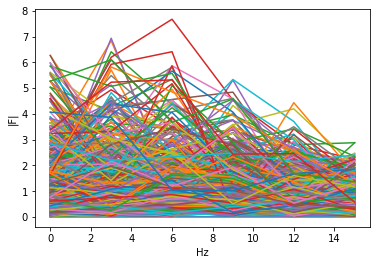

In [17]:
tap = 10
dt = 1/fps
ft = rfftfreq(tap, dt)

FF = F.reshape(tap,-1)
plt.plot(ft, FF[:len(ft),:])
plt.xlabel('Hz')
plt.ylabel('|F|')

ft

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

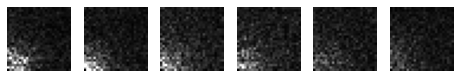

In [19]:
fx = rfftfreq(52, 33/1000)
FFF = F[:len(ft),:len(fx),:len(fx)]
FFF.shape
pysta.plot_stim_slices(FFF, FFF.shape[1], FFF.shape[2], vmin=0, vmax=np.median(FFF.ravel())*10)

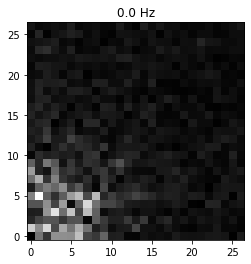

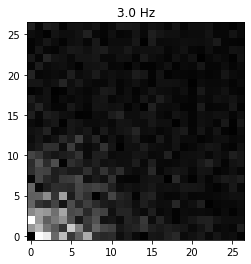

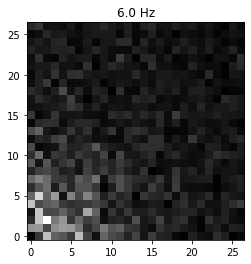

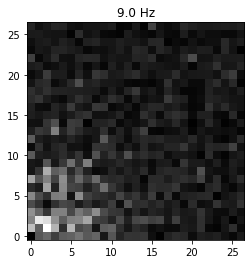

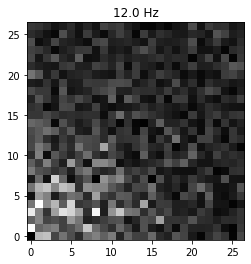

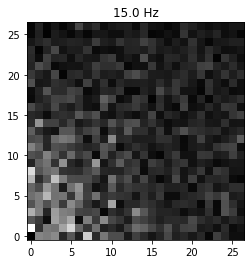

In [20]:
for i in range(FFF.shape[0]):
    plt.figure()
    plt.imshow(FFF[i,:,:], cmap='gray', origin='lower')    
#     plt.imshow(np.log(FFF[i,:,:]), cmap='gray', origin='lower')
    plt.title('{} Hz'.format(ft[i]))